| **Chapter**                   | 8:  Spatial dynamics of epidemics                |
| ----------------------------- |--------------------------------------------------|
| **Computational Note**        | 8.x: Reston virus                                |
| **Package prerequisites**     | [osmnx](https://osmnx.readthedocs.io/en/stable/) |


# Hospital accessibility in Oxford, England

In [1]:
import osmnx
import geopandas as gpd
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import networkx as nx

In [2]:
%load_ext watermark
%watermark --iversions -v -a "Chris von Csefalvay" -gu "chrisvoncsefalvay"

Author: Chris von Csefalvay

Github username: chrisvoncsefalvay

Python implementation: CPython
Python version       : 3.10.2
IPython version      : 8.4.0

osmnx     : 1.2.0
networkx  : 2.8.4
matplotlib: 3.5.2
numpy     : 1.21.6
geopandas : 0.10.2
pandas    : 1.4.2



In [3]:
location = "Reston, VA"

source_address = "1946 Isaac Newton Square W, Reston, Virginia"
sourcey, sourcex = osmnx.geocode(source_address)

In [4]:
%%time

graph = osmnx.graph_from_point(center_point=(sourcey, sourcex), dist=25_000, dist_type="bbox", network_type="drive")
graph = osmnx.distance.add_edge_lengths(graph)

nodes, edges = osmnx.graph_to_gdfs(graph, nodes=True, edges=True, node_geometry=True)

CPU times: user 3min 18s, sys: 23.1 s, total: 3min 41s
Wall time: 6min 18s


In [5]:
speed_limits = {
    "residential": 30,
    "motorway": 55,
    "road": 40
}

In [6]:
def determine_max_speed(row):
    if isinstance(row.maxspeed, list):
        if ";" in row.maxspeed[0]:
            return row.maxspeed.split(";")[0]
        elif "mph" in row.maxspeed[0]:
            return float(row.maxspeed[0].replace(" mph", ""))
        else:
            return float(row.maxspeed[0])
    elif not pd.isna(row.maxspeed):
        if ";" in row.maxspeed:
            spd = row.maxspeed.split(";")[0]
        else:
            spd = row.maxspeed
            return float(spd.replace(" mph", ""))
    elif row.highway in list(speed_limits.keys()):
        return speed_limits[row.highway]
    else:
        return 35.0

In [7]:
edges["max_mph"] = edges.apply(determine_max_speed, axis=1)

In [8]:
edges.geometry = edges.geometry.to_crs("+proj=cea")
edges = edges.reset_index()
nodes.geometry = nodes.geometry.to_crs("+proj=cea")

In [9]:
edges = edges[["geometry", "u", "v", "length", "max_mph", "highway", "oneway"]].to_crs("+proj=cea")
nodes = nodes.to_crs("+proj=cea")

In [10]:
edges.max_mph.unique()

array([30.  , 25.  , 35.  , 55.  , 15.  , 45.  , 40.  , 20.  ,  5.  ,
       50.  , 14.  , 10.  , 65.  , 24.14,   nan, 60.  ])

In [11]:
edges["travel_time"] = (edges.length * 0.000621371)/(edges.max_mph / 60)

In [12]:
edges.geometry = edges.geometry.to_crs(4326)
nodes.geometry = nodes.geometry.to_crs(4326)

In [13]:
graph = osmnx.project_graph(graph, to_crs=4326)

In [14]:
monkeyhouse, distance_to_monkeyhouse = osmnx.distance.nearest_nodes(graph, X=sourcex, Y=sourcey, return_dist=True)
travel_times = nx.single_source_dijkstra_path_length(graph, source=monkeyhouse, weight="travel_time")

In [15]:
times = pd.DataFrame([list(travel_times.keys()), list(travel_times.values())]).T

In [16]:
nodes = nodes.reset_index()

In [17]:
times.columns = ["node_id", "travel_time"]

In [18]:
n = nodes.merge(times, left_on="osmid", right_on="node_id")

In [19]:
arterial_roads = edges.loc[edges.highway.isin(["motorway", "trunk", "primary", "primary_link"])]

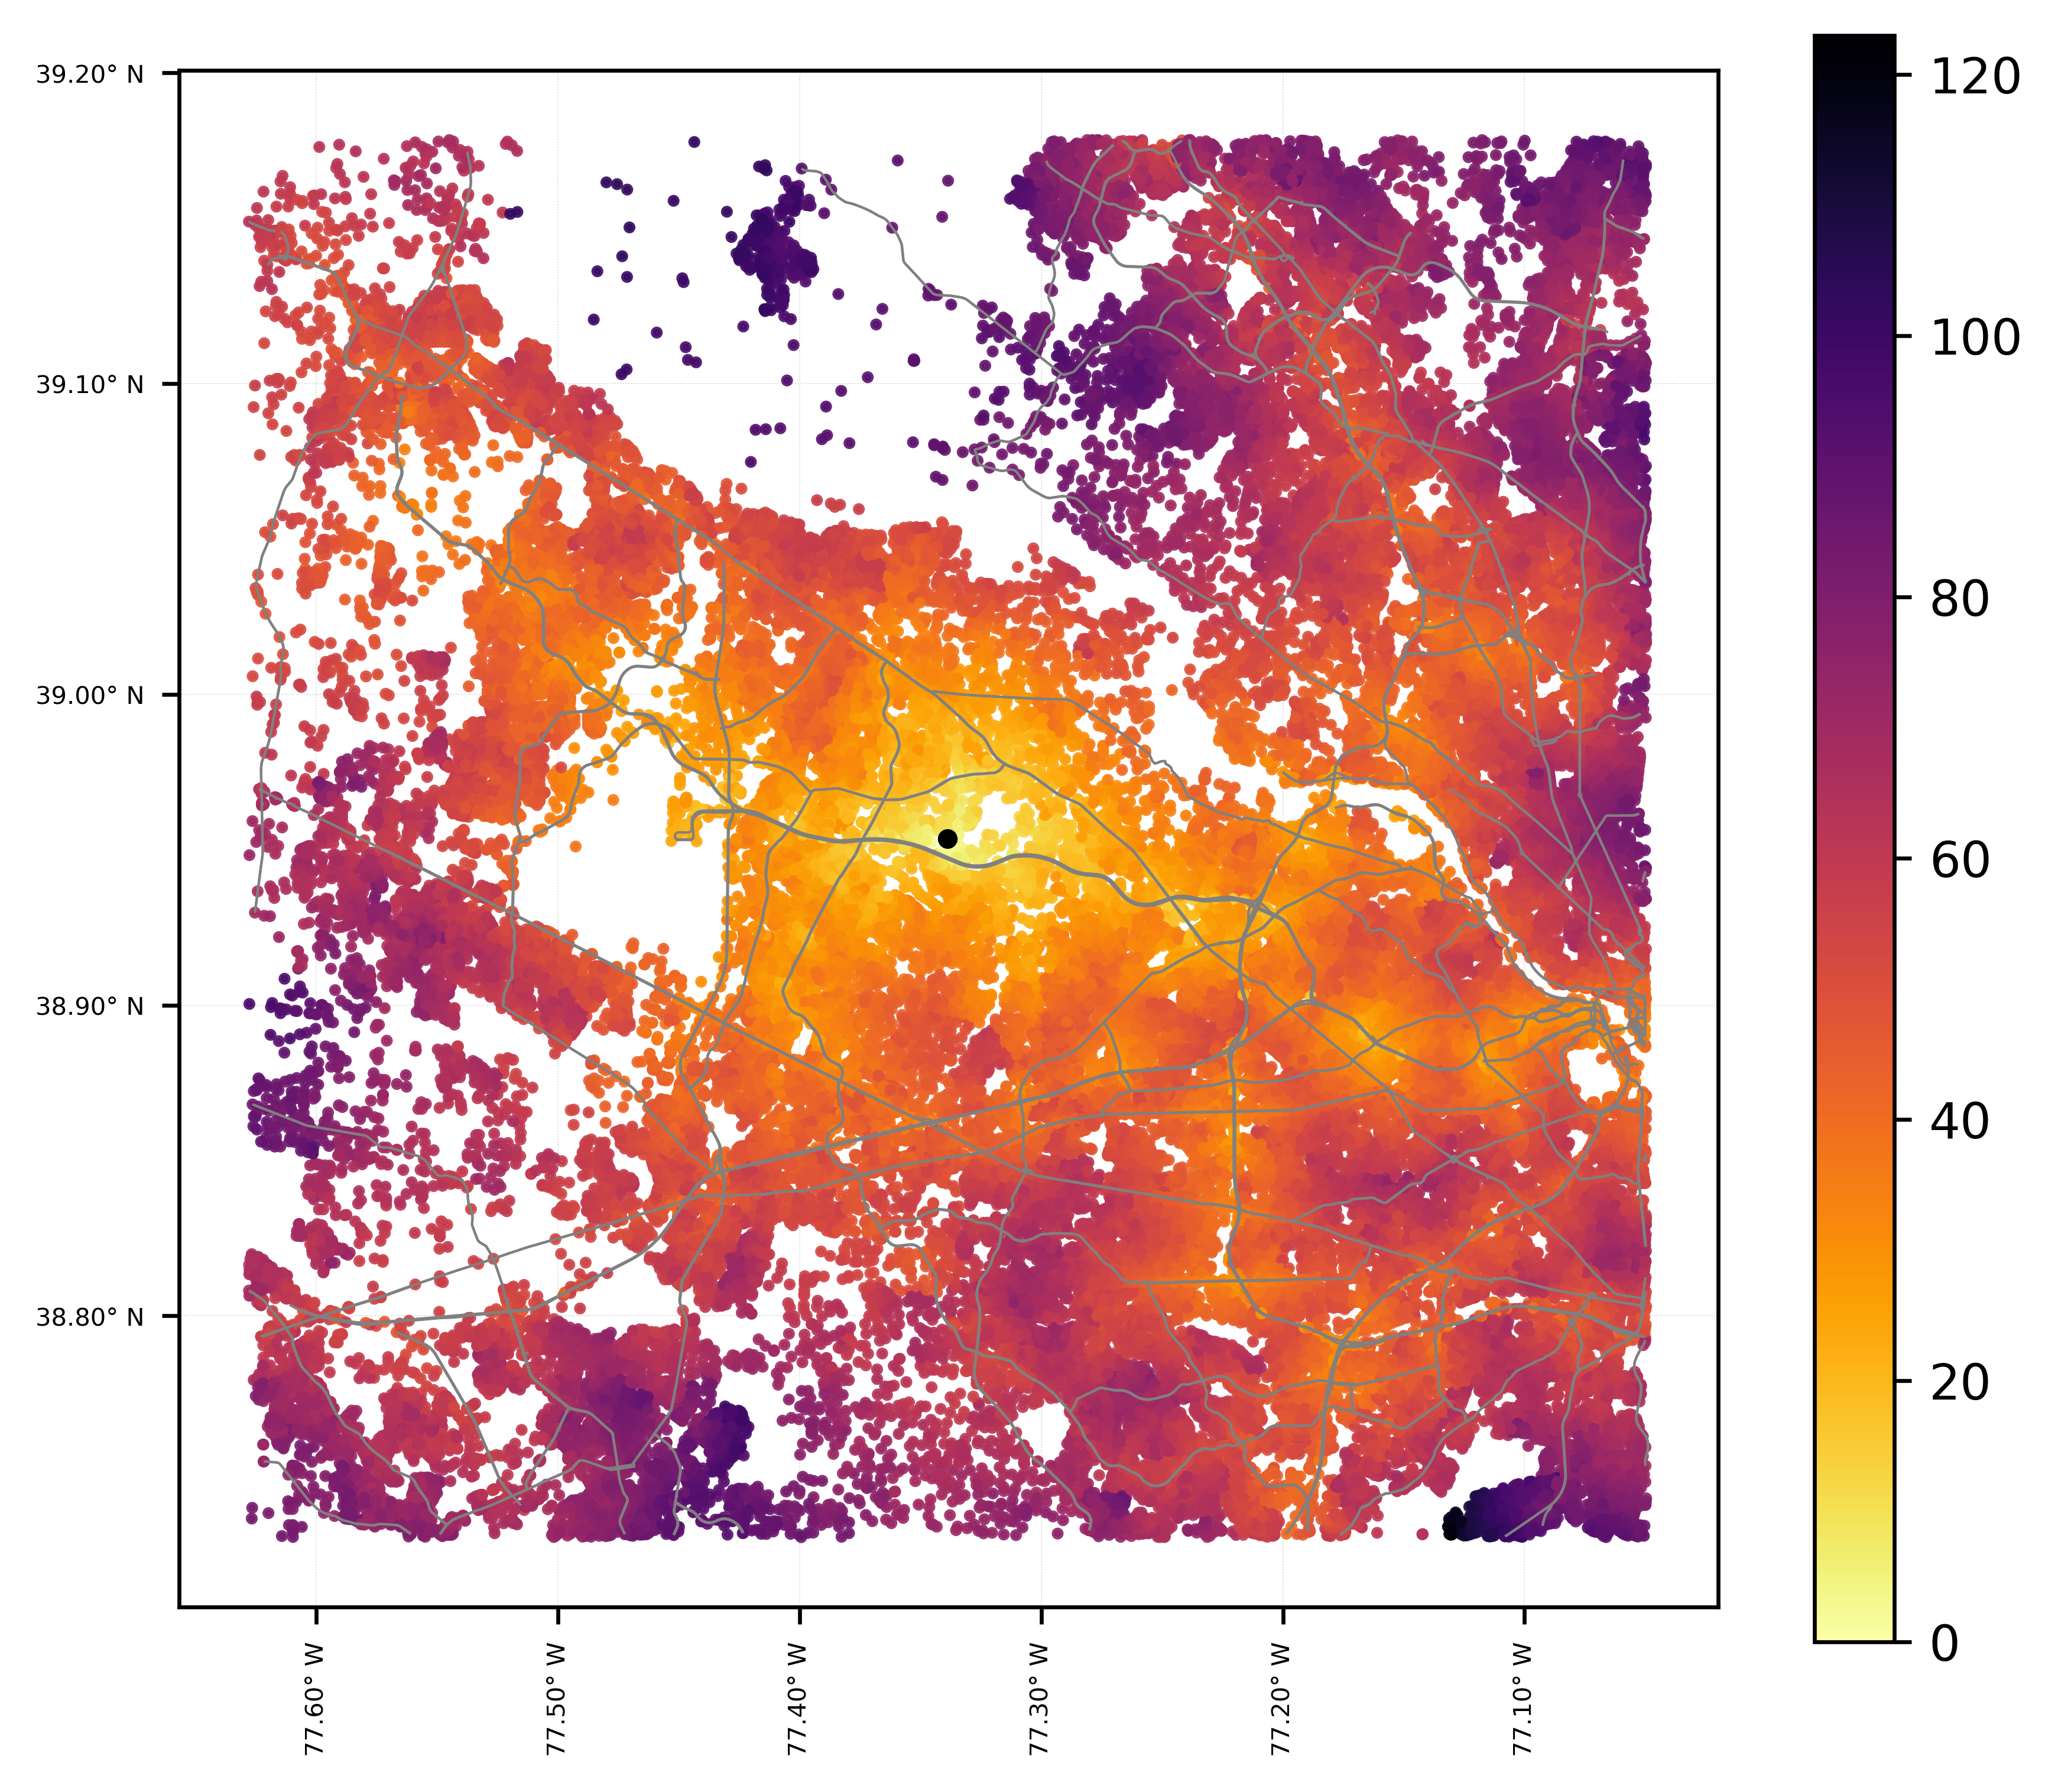

In [20]:
fig = plt.figure(facecolor="w", figsize=(7, 6), dpi=600)
ax = fig.add_subplot(111, axisbelow=True)

arterial_roads.plot(ax=ax, lw=0.5, color='gray', zorder=3)
ax.plot(sourcex, sourcey, ".k")
ax = n.plot("travel_time", ax=ax, cmap="inferno_r", markersize=2, legend=True, alpha = 0.9)

ax.tick_params(axis="x", labelsize=5, rotation=90, grid_alpha=0.2, grid_linewidth=0.2, grid_color="k", grid_linestyle=":")
ax.tick_params(axis="y", labelsize=5, grid_alpha=0.2, grid_linewidth=0.2, grid_color="k", grid_linestyle=":")
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, y: f"{np.abs(x):.2f}° W"))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, y: f"{np.abs(x):.2f}° N"))
ax.grid()

plt.savefig("reston_virus.pdf")